In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf, kwant_examples, model
from tqdm import tqdm

Now we show the interface with `kwant`. We start by using `kwant` to build two tight-binding systems with translational symmetry:
* graphene;
* a dummy `kwant.Builder` that encodes the interaction matrix.
See [`kwant_examples`](./codes/kwant_examples.py) to verify how these two steps are done.

In [2]:
def flat_to_matrix(flat, shape):
    matrix = np.zeros(shape, dtype=complex)
    matrix[:, :, *np.triu_indices(shape[-1])] = flat.reshape(shape[0], shape[1], -1)
    lower_triangle_wo_diag = matrix.transpose(0, 1, 3, 2)[
        :, :, *np.tril_indices(shape[-1], k=-1)
    ]
    matrix[:, :, *np.tril_indices(shape[-1], k=-1)] = lower_triangle_wo_diag.reshape(
        shape[0], shape[1], -1
    ).conj()

    return matrix

def matrix_to_flat(matrix):
    matrix[
        :,
        :,
        *np.triu_indices(matrix.shape[-1]),
    ].flatten()

def upper_triangle_cost(delta_mf_flatten, model):
    mfk_shape = model.mf_k.shape

    # From flat to non-flat:
    mf_delta_shaped = flat_to_matrix(delta_mf_flatten, mfk_shape)

    # Doing the update
    mf_shaped = model.mf_k + mf_delta_shaped
    _, model.mf_k = hf.updated_matrices(mf_k=mf_shaped, model=model)
    delta_mf = mf_shaped - model.mf_k

    # Now flattening again
    return matrix_to_flat(delta_mf)

In [3]:
# Create translationally-invariant `kwant.Builder`
graphene_builder, int_builder = kwant_examples.graphene_extended_hubbard()

We then use `utils.builder2tb_model` to parse the `kwant.Builder` to a `tb_model` that we will use in the self-consistent calculations.

In [4]:
tb_model = utils.builder2tb_model(graphene_builder)

Note that the self-consistent loop is performed on a coarse k-point grid, and thus not necessarily appropriate to compute observables. We thus use `utils.kgrid_hamiltonian` to evaluate the Hamiltonian on a denser k-point grid and compute the gap.

In [5]:
params = dict(U=1, V=1)
int_model = utils.builder2tb_model(int_builder, params)
mf_model = model.Model(tb_model, int_model=int_model)

In [17]:
def compute_gap(
    model,
    nk,
    nk_dense,
    filling=2,
    guess=None,
):

    model.guess = guess

    # Find groundstate Hamiltonian on the same grid
    mf_model = hf.find_groundstate_ham(
        model,
        filling=filling,
        nk=nk,
        cutoff_Vk=1,
        optimizer_kwargs={'M':0}
    )

    mf_k = utils.kgrid_hamiltonian(  # only used for diagonalization to get gap
        nk=nk_dense,
        hk=utils.model2hk(tb_model=mf_model),
        dim=2
    )
    # Diagonalize groundstate Hamiltonian
    vals, _ = np.linalg.eigh(mf_k)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, filling)
    gap = utils.calc_gap(vals, E_F)

    # the guess was kind of unclear
    return gap, None#, mf_model

Finally, we also parse `int_builder` with the wanted interaction strength. Note that we pass a `params` dictionary to evaluate the Hamiltonian with `kwant`.

In [19]:
def compute_phase_diagram(Us, Vs, nk, nk_dense):
    gap = []
    for U in tqdm(Us):
        guess = None
        gap_U = []
        for V in Vs:#tqdm(Vs):
            params = dict(U=U, V=V)
            int_model = utils.builder2tb_model(int_builder, params)
            mf_model = model.Model(tb_model, int_model=int_model)
            _gap, guess = compute_gap(
                model=mf_model,
                nk=nk,
                nk_dense=nk_dense,
                guess=guess,
            )
            gap_U.append(_gap)
        gap.append(gap_U)
    return np.asarray(gap, dtype=float)

**Warning:** this phase diagram calculation takes about one hour.

In [20]:
# Generate dense-grid k-points
# Interaction strengths
nk = 20
nk_dense = 30
Us = np.linspace(0, 3, 10, endpoint=True)
Vs = np.linspace(0, 1.5, 10, endpoint=True)
gap = compute_phase_diagram(Us, Vs, nk=nk, nk_dense=nk_dense)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [16:50<00:00, 101.02s/it]


In [21]:
import xarray as xr

gap_da = xr.DataArray(data=gap, coords=dict(Us=Us, Vs=Vs))

We note that the gap openings coincide with the phase transitions from gapless to charge density wave or antiferromagnetic groundstates as predicted in [arXiv:1204.4531](https://arxiv.org/abs/1204.4531). 

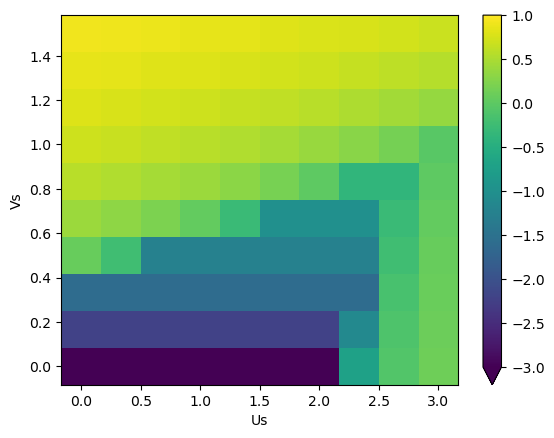

In [22]:
np.log10(gap_da).plot(x="Us", y="Vs", vmin=-3, vmax=1)

In [9]:
gap_da.to_netcdf("./data/graphene_example.nc")